Data from here: https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset

In [3]:
from bs4 import BeautifulSoup as bsoup
import requests
import pandas as pd
import numpy as np
import string

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library 

import plotly.express as px
import plotly.graph_objects as go

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from scipy.stats.mstats import normaltest
from scipy.stats import boxcox

# Data from UCI

In [4]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip

--2021-08-12 16:03:01--  https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 279992 (273K) [application/x-httpd-php]
Saving to: ‘Bike-Sharing-Dataset.zip’

Bike-Sharing-Datase 100%[===================>] 273.43K  1.03MB/s    in 0.3s    

2021-08-12 16:03:02 (1.03 MB/s) - ‘Bike-Sharing-Dataset.zip’ saved [279992/279992]



In [5]:
from zipfile import ZipFile

with ZipFile('/content/Bike-Sharing-Dataset.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

In [6]:
day=pd.read_csv('day.csv')

In [7]:
day.dteday = day.dteday.apply(pd.to_datetime)
day['day'] = day['dteday'].dt.day
day.set_index(day.dteday,inplace=True)

In [8]:
day.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,day
dteday,,,,,,,,,,,,,,,,,
2011-01-01,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985,1
2011-01-02,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801,2
2011-01-03,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349,3
2011-01-04,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562,4
2011-01-05,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600,5


In [9]:
day.dtypes

instant                int64
dteday        datetime64[ns]
season                 int64
yr                     int64
mnth                   int64
holiday                int64
weekday                int64
workingday             int64
weathersit             int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
cnt                    int64
day                    int64
dtype: object

In [10]:
day.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,day
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,366.000000,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837,15.738714
std,211.165812,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452,8.809949
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000,1.000000
25%,183.500000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000,8.000000
50%,366.000000,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000,16.000000
75%,548.500000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000,23.000000
max,731.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000,31.000000


In [11]:
#instant	dteday	season	yr	mnth	holiday	weekday	workingday	weathersit	temp	atemp	hum	windspeed	casual	registered	cnt

- set index to dteday
- autocorrelations

In [12]:
day.index.max()-day.index.min()

Timedelta('730 days 00:00:00')

# Daily Rides

In [13]:
fig = go.Figure(data=go.Scatter(x=day.index, y=day['cnt'], mode='lines', marker=dict(color='green')))
fig.update_layout(title='Rides per Day', xaxis_title='Date', yaxis_title='Rides per Month')
fig.show()

# Monthly Rides

In [14]:
rpm=day.resample('M').sum()
fig = go.Figure(data=go.Scatter(x=rpm.index, y=rpm['cnt'], mode='lines', marker=dict(color='green')))
fig.update_layout(title='Rides per Month', xaxis_title='Date', yaxis_title='Rides per Month')
fig.show()

In [15]:
day.resample('M').sum()['cnt']

dteday
2011-01-31     38189
2011-02-28     48215
2011-03-31     64045
2011-04-30     94870
2011-05-31    135821
2011-06-30    143512
2011-07-31    141341
2011-08-31    136691
2011-09-30    127418
2011-10-31    123511
2011-11-30    102167
2011-12-31     87323
2012-01-31     96744
2012-02-29    103137
2012-03-31    164875
2012-04-30    174224
2012-05-31    195865
2012-06-30    202830
2012-07-31    203607
2012-08-31    214503
2012-09-30    218573
2012-10-31    198841
2012-11-30    152664
2012-12-31    123713
Freq: M, Name: cnt, dtype: int64

In [16]:
rpd = day['cnt']
rpd.head()

dteday
2011-01-01     985
2011-01-02     801
2011-01-03    1349
2011-01-04    1562
2011-01-05    1600
Name: cnt, dtype: int64

# SARIMA / FBProphet

In [17]:
rpd

dteday
2011-01-01     985
2011-01-02     801
2011-01-03    1349
2011-01-04    1562
2011-01-05    1600
              ... 
2012-12-27    2114
2012-12-28    3095
2012-12-29    1341
2012-12-30    1796
2012-12-31    2729
Name: cnt, Length: 731, dtype: int64

In [18]:
#rpd2=pd.DataFrame(data=rpd,columns=['ds','y'])
rpd2=pd.DataFrame(data=rpd)

In [19]:
rpd2.rename(columns={'cnt':'y'},inplace=True)
#rpd2.index.rename('ds',inplace=True)
rpd2['ds']=rpd2.index

In [20]:
rpd2

,y,ds
dteday,,
2011-01-01,985,2011-01-01
2011-01-02,801,2011-01-02
2011-01-03,1349,2011-01-03
2011-01-04,1562,2011-01-04
2011-01-05,1600,2011-01-05
...,...,...
2012-12-27,2114,2012-12-27
2012-12-28,3095,2012-12-28
2012-12-29,1341,2012-12-29


In [21]:
from fbprophet import Prophet
m = Prophet()
m.fit(rpd2)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [22]:
future = m.make_future_dataframe(periods=365)
print(future.head())
print(future.tail())

          ds
0 2011-01-01
1 2011-01-02
2 2011-01-03
3 2011-01-04
4 2011-01-05
             ds
1091 2013-12-27
1092 2013-12-28
1093 2013-12-29
1094 2013-12-30
1095 2013-12-31


In [23]:
forecast = m.predict(future)
print(forecast.columns)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')


,ds,yhat,yhat_lower,yhat_upper
1091,2013-12-27,5652.278047,4434.127189,6906.898860
1092,2013-12-28,5568.985005,4319.620267,6797.594281
1093,2013-12-29,5271.797263,3960.475180,6451.220997
1094,2013-12-30,5417.560173,4192.621119,6746.552933
1095,2013-12-31,5633.194627,4389.229479,6887.246807


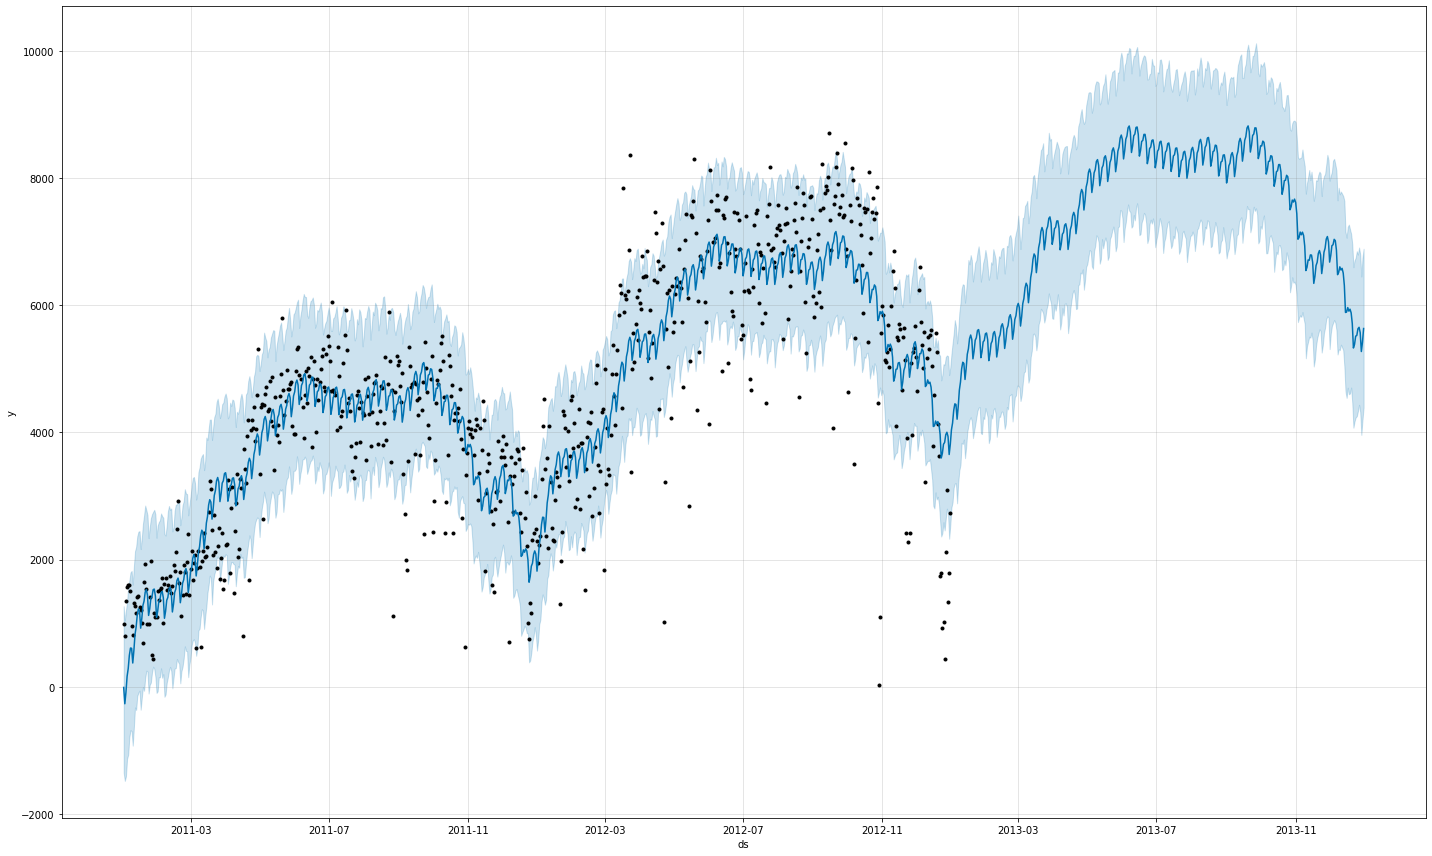

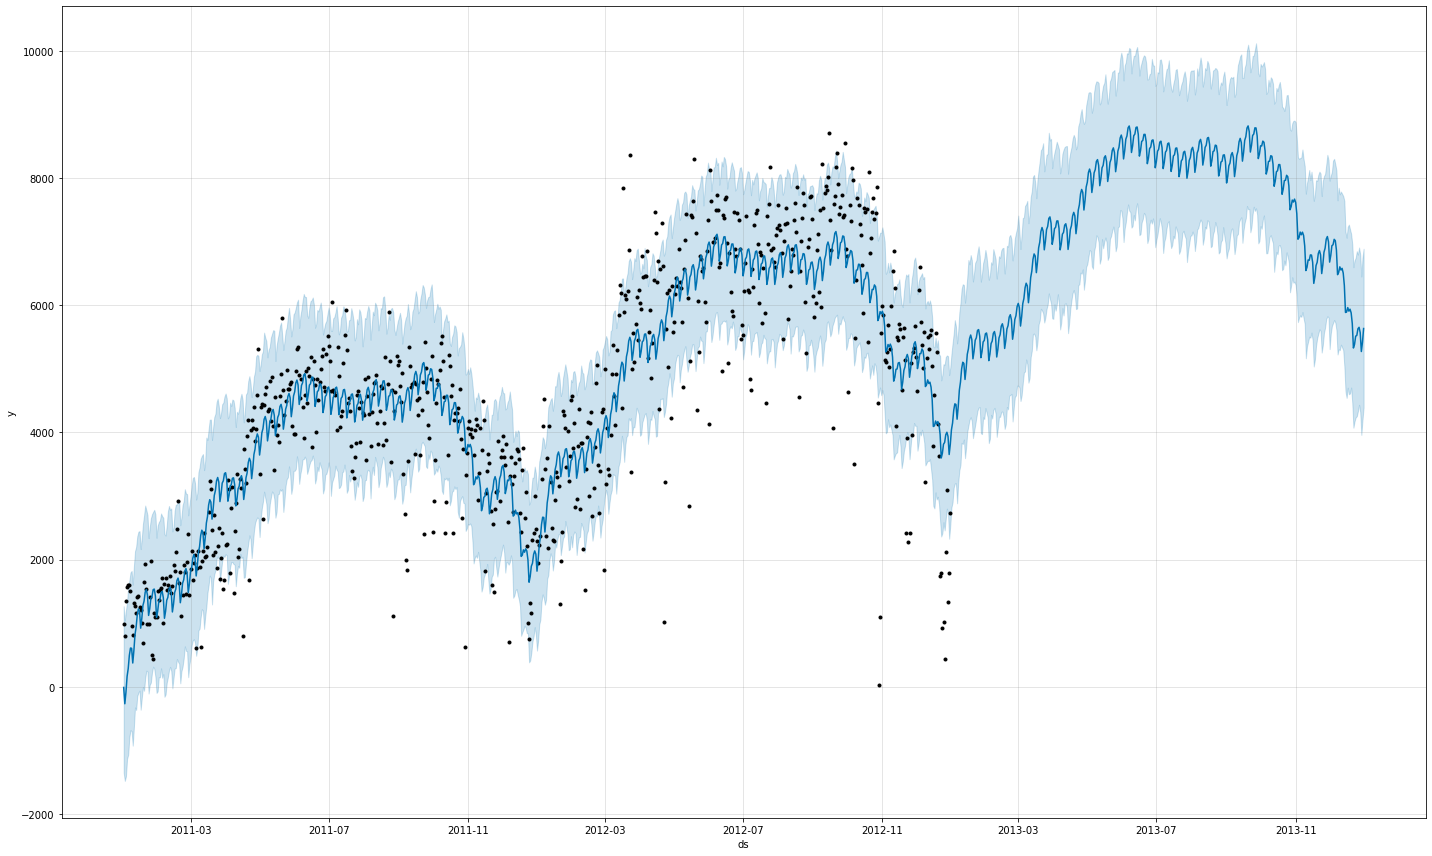

In [24]:
from fbprophet.plot import plot

plot(m, forecast, figsize=(20, 12))

#m.plot(forecast);

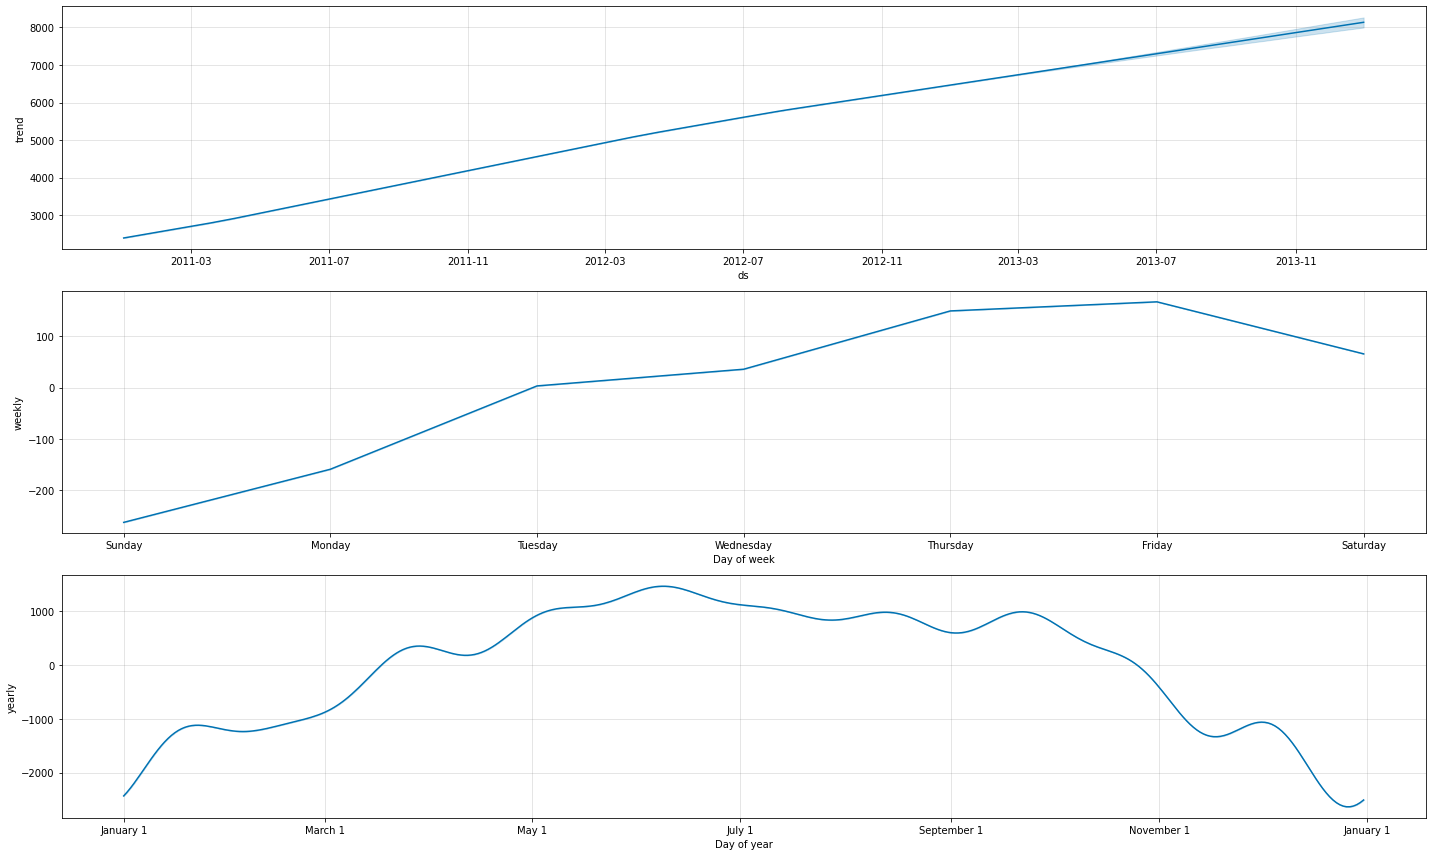

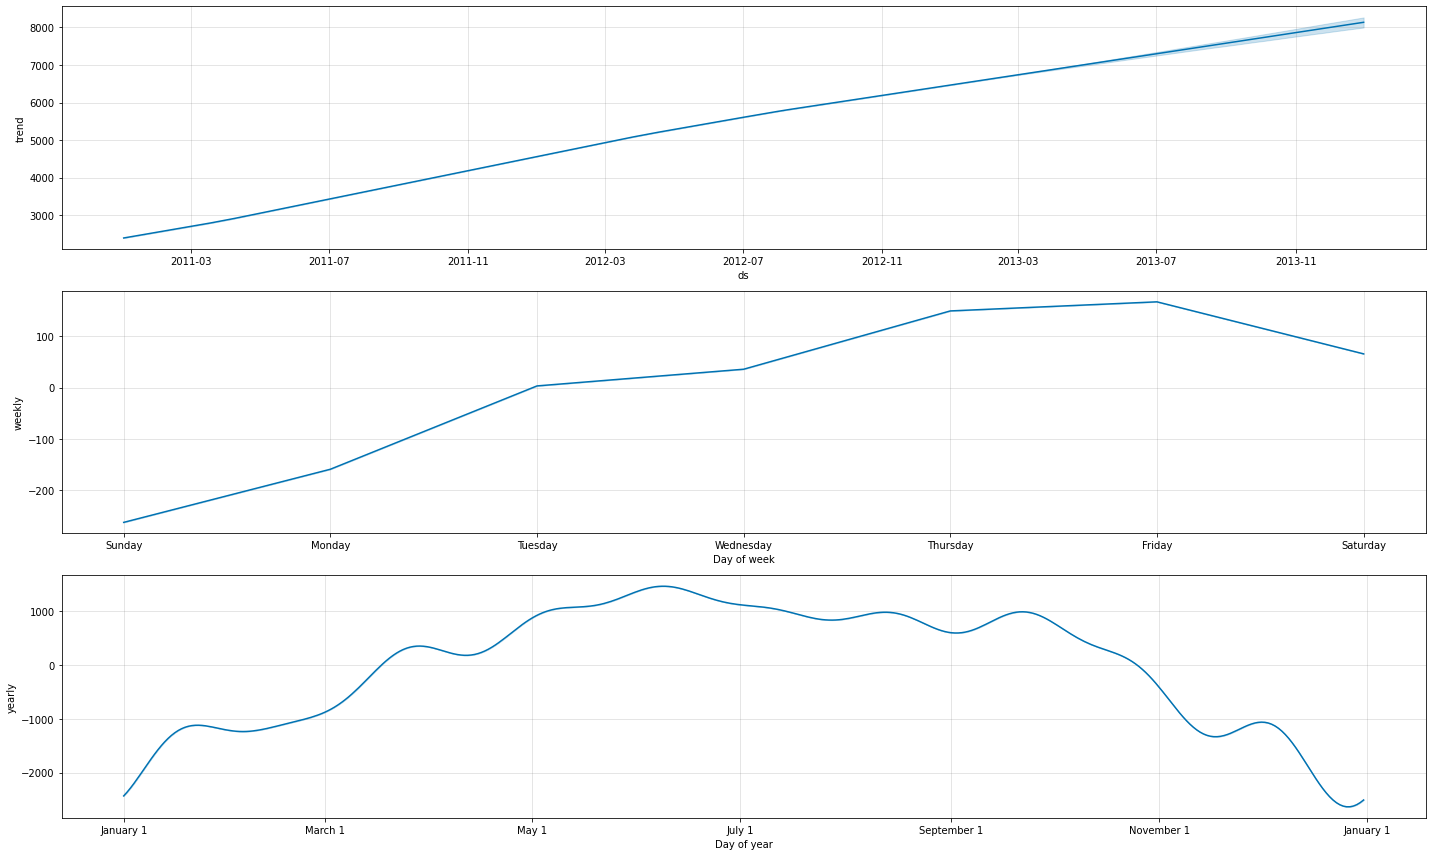

In [25]:
from fbprophet.plot import plot_components
plot_components(m=m,fcst=forecast, figsize=(20, 12))
#m.plot_components(forecast);

# DeepAR

In [26]:
pip install --upgrade mxnet

In [27]:
pip install gluonts

In [28]:
rpd2


,y,ds
dteday,,
2011-01-01,985,2011-01-01
2011-01-02,801,2011-01-02
2011-01-03,1349,2011-01-03
2011-01-04,1562,2011-01-04
2011-01-05,1600,2011-01-05
...,...,...
2012-12-27,2114,2012-12-27
2012-12-28,3095,2012-12-28
2012-12-29,1341,2012-12-29


In [29]:
pd.Timestamp("2011-01-01", freq="D")

Timestamp('2011-01-01 00:00:00', freq='D')

In [30]:
rpd3=rpd2.copy(deep=True)
rpd3=rpd3.reset_index(drop=False)

In [31]:
rpd3

,dteday,y,ds
0,2011-01-01,985,2011-01-01
1,2011-01-02,801,2011-01-02
2,2011-01-03,1349,2011-01-03
3,2011-01-04,1562,2011-01-04
4,2011-01-05,1600,2011-01-05
...,...,...,...
726,2012-12-27,2114,2012-12-27
727,2012-12-28,3095,2012-12-28
728,2012-12-29,1341,2012-12-29
729,2012-12-30,1796,2012-12-30


In [ ]:
tot_samples=730
prediction_length=360

In [ ]:
from gluonts.dataset.common import ListDataset
start = pd.Timestamp("2011-01-01", freq="D")
# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
train_ds = ListDataset([{'target': rpd3.loc[:(tot_samples-prediction_length),'y'], 'start': start}], freq='D')
# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = ListDataset([{'target': rpd3['y'], 'start': start}],freq='D')

In [ ]:
from gluonts.mx.trainer import Trainer

In [ ]:
from gluonts.model.deepar import DeepAREstimator
#from gluonts.trainer import Trainer
import mxnet as mx
import numpy as np
np.random.seed(7)
mx.random.seed(7)
estimator = DeepAREstimator(prediction_length=prediction_length,context_length=100,freq='D',
  trainer=Trainer( epochs=5,learning_rate=1e-3,num_batches_per_epoch=100))
predictor = estimator.train(train_ds)

INFO:gluonts.trainer:Start model training
INFO:gluonts.trainer:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [01:27<00:00,  1.15it/s, epoch=1/5, avg_epoch_loss=8.46]
INFO:gluonts.trainer:Epoch[0] Elapsed time 87.238 seconds
INFO:gluonts.trainer:Epoch[0] Evaluation metric 'epoch_loss'=8.455978
INFO:gluonts.trainer:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [01:19<00:00,  1.26it/s, epoch=2/5, avg_epoch_loss=7.83]
INFO:gluonts.trainer:Epoch[1] Elapsed time 79.592 seconds
INFO:gluonts.trainer:Epoch[1] Evaluation metric 'epoch_loss'=7.829616
INFO:gluonts.trainer:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [01:17<00:00,  1.29it/s, epoch=3/5, avg_epoch_loss=7.71]
INFO:gluonts.trainer:Epoch[2] Elapsed time 77.733 seconds
INFO:gluonts.trainer:Epoch[2] Evaluation metric 'epoch_loss'=7.714629
INFO:gluonts.trainer:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [01:18<00:00,  1.28it/s, epoch=4/5, avg_epoch_loss=7.6]
INFO:gluonts.trainer:Epoch[3] Elaps

In [ ]:
predictions = predictor.predict(test_ds)
predictions = list(predictions)[0]
predictions = predictions.quantile(0.5)

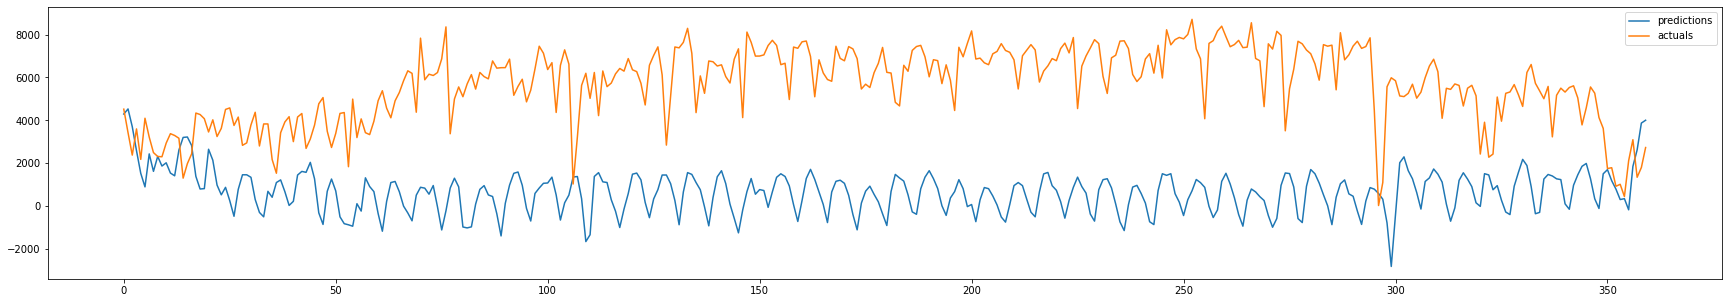

In [ ]:
from sklearn.metrics import r2_score
#print(r2_score( list(test_ds)[0]['target'][-28:], predictions))
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(30,5))
plt.plot(predictions)
plt.plot(list(test_ds)[0]['target'][-prediction_length:])
plt.legend(['predictions', 'actuals'])
plt.show()

INFO:gluonts.trainer:Start model training
INFO:gluonts.trainer:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [01:17<00:00,  1.29it/s, epoch=1/5, avg_epoch_loss=8.46]
INFO:gluonts.trainer:Epoch[0] Elapsed time 77.230 seconds
INFO:gluonts.trainer:Epoch[0] Evaluation metric 'epoch_loss'=8.455978
INFO:gluonts.trainer:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [01:11<00:00,  1.40it/s, epoch=2/5, avg_epoch_loss=7.83]
INFO:gluonts.trainer:Epoch[1] Elapsed time 71.439 seconds
INFO:gluonts.trainer:Epoch[1] Evaluation metric 'epoch_loss'=7.829616
INFO:gluonts.trainer:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [01:11<00:00,  1.40it/s, epoch=3/5, avg_epoch_loss=7.71]
INFO:gluonts.trainer:Epoch[2] Elapsed time 71.342 seconds
INFO:gluonts.trainer:Epoch[2] Evaluation metric 'epoch_loss'=7.714629
INFO:gluonts.trainer:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [01:11<00:00,  1.40it/s, epoch=4/5, avg_epoch_loss=7.6]
INFO:gluonts.trainer:Epoch[3] Elaps

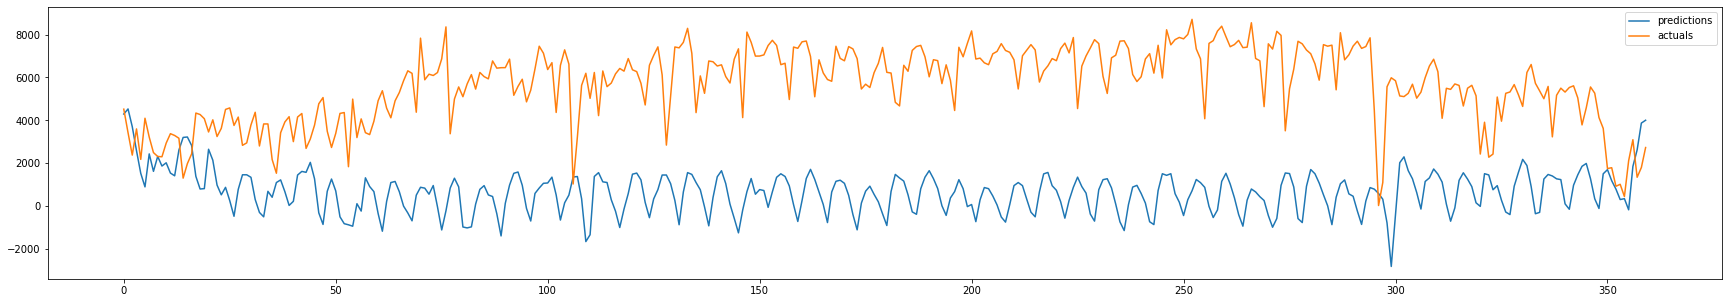

In [33]:
!pip install --upgrade mxnet
!pip install gluonts

tot_samples=730
prediction_length=360

from gluonts.dataset.common import ListDataset
start = pd.Timestamp("2011-01-01", freq="D")
train_ds = ListDataset([{'target': rpd3.loc[:(tot_samples-prediction_length),'y'], 'start': start}], freq='D')
test_ds = ListDataset([{'target': rpd3['y'], 'start': start}],freq='D')

from gluonts.mx.trainer import Trainer
from gluonts.model.deepar import DeepAREstimator
import mxnet as mx
import numpy as np
np.random.seed(7)
mx.random.seed(7)
estimator = DeepAREstimator(prediction_length=prediction_length,context_length=100,freq='D',
  trainer=Trainer( epochs=5,learning_rate=1e-3,num_batches_per_epoch=100))
predictor = estimator.train(train_ds)

predictions = predictor.predict(test_ds)
predictions = list(predictions)[0]
predictions = predictions.quantile(0.5)

from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(30,5))
plt.plot(predictions)
plt.plot(list(test_ds)[0]['target'][-prediction_length:])
plt.legend(['predictions', 'actuals'])
plt.show()

